Mounted at /content/drive
Epoch 1/20
113/113 - 4s - 39ms/step - accuracy: 0.6053 - loss: 0.7266 - val_accuracy: 0.6210 - val_loss: 0.6435
Epoch 2/20
113/113 - 1s - 13ms/step - accuracy: 0.7397 - loss: 0.5309 - val_accuracy: 0.6990 - val_loss: 0.5879
Epoch 3/20
113/113 - 2s - 17ms/step - accuracy: 0.8064 - loss: 0.4338 - val_accuracy: 0.7347 - val_loss: 0.5377
Epoch 4/20
113/113 - 1s - 8ms/step - accuracy: 0.8530 - loss: 0.3543 - val_accuracy: 0.7469 - val_loss: 0.5332
Epoch 5/20
113/113 - 1s - 11ms/step - accuracy: 0.8856 - loss: 0.2974 - val_accuracy: 0.7614 - val_loss: 0.5267
Epoch 6/20
113/113 - 1s - 11ms/step - accuracy: 0.9024 - loss: 0.2640 - val_accuracy: 0.7737 - val_loss: 0.5367
Epoch 7/20
113/113 - 1s - 8ms/step - accuracy: 0.9266 - loss: 0.2201 - val_accuracy: 0.7759 - val_loss: 0.5659
Epoch 8/20
113/113 - 1s - 11ms/step - accuracy: 0.9244 - loss: 0.2070 - val_accuracy: 0.7703 - val_loss: 0.5722
✅ Model saved to: /content/drive/MyDrive/RNA-peptide/rna_peptide_dual_model_with

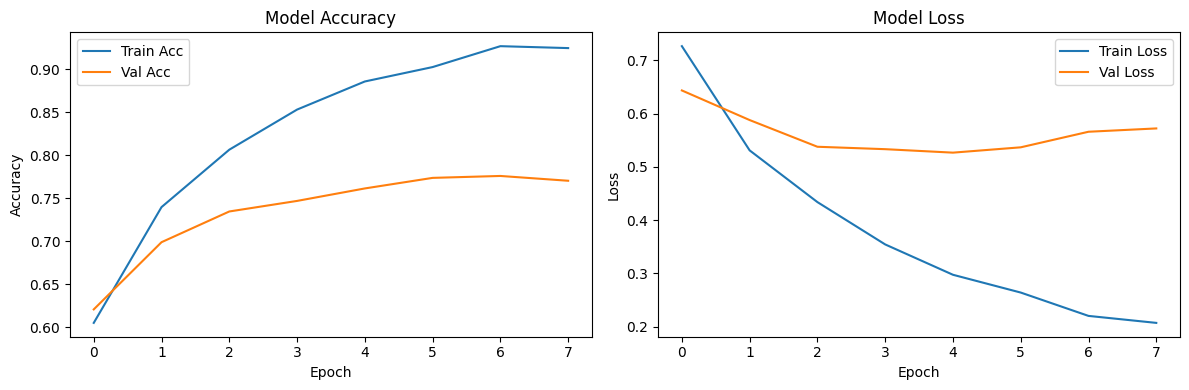

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7513 - loss: 0.5568

✅ Final Test Accuracy: 0.7614 | Test Loss: 0.5267


In [1]:
# ✅ STEP 1: Setup
!pip install -q tensorflow
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Concatenate, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import os

# ✅ STEP 2: Mount Drive
from google.colab import drive
drive.mount('/content/drive')

# ✅ STEP 3: Load data (positive + negative)
csv_path = '/content/drive/MyDrive/RNA-peptide/rna_protein_positive_negative_pairs_full_combined.csv'
df = pd.read_csv(csv_path)

df['label'] = df['pdb_id'].apply(lambda x: 0 if '_neg' in str(x) else 1)

# ✅ STEP 4: Define vocab dictionaries
rna_vocab = list("AUGC")
aa_vocab = list("ACDEFGHIKLMNPQRSTVWY")
rna_dict = {ch: i for i, ch in enumerate(rna_vocab)}
aa_dict = {ch: i for i, ch in enumerate(aa_vocab)}

# ✅ STEP 5: One-hot encoding function
def one_hot_encode(seq, vocab_dict, max_len):
    encoded = np.zeros((max_len, len(vocab_dict)))
    for i, ch in enumerate(seq[:max_len]):
        if ch in vocab_dict:
            encoded[i, vocab_dict[ch]] = 1
    return encoded.flatten()

MAX_RNA_LEN = 100
MAX_PEP_LEN = 100

rna_encoded = np.array([one_hot_encode(seq, rna_dict, MAX_RNA_LEN) for seq in df['rna_seq']])
pep_encoded = np.array([one_hot_encode(seq, aa_dict, MAX_PEP_LEN) for seq in df['protein_seq']])
labels = df['label'].values

# ✅ STEP 6: Train-test split
X_train_rna, X_test_rna, X_train_pep, X_test_pep, y_train, y_test = train_test_split(
    rna_encoded, pep_encoded, labels, test_size=0.2, random_state=42
)

# ✅ STEP 7: Model builder with improvements
def build_model(input_rna_dim, input_pep_dim):
    rna_input = Input(shape=(input_rna_dim,), name='rna_input')
    pep_input = Input(shape=(input_pep_dim,), name='peptide_input')

    x1 = Dense(128, activation='relu')(rna_input)
    x1 = BatchNormalization()(x1)
    x1 = Dropout(0.3)(x1)

    x2 = Dense(128, activation='relu')(pep_input)
    x2 = BatchNormalization()(x2)
    x2 = Dropout(0.3)(x2)

    merged = Concatenate()([x1, x2])
    interaction_features = Dense(64, activation='relu', name='interaction_features')(merged)
    output = Dense(1, activation='sigmoid')(interaction_features)

    model = Model(inputs=[rna_input, pep_input], outputs=output)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model

# ✅ STEP 8: Build + train model with early stopping
model = build_model(rna_encoded.shape[1], pep_encoded.shape[1])
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(
    [X_train_rna, X_train_pep],
    y_train,
    epochs=20,
    batch_size=32,
    validation_data=([X_test_rna, X_test_pep], y_test),
    callbacks=[early_stop],
    verbose=2
)

# ✅ STEP 9: Save model in .keras format
model_path = '/content/drive/MyDrive/RNA-peptide/rna_peptide_dual_model_with_4486.keras'
model.save(model_path)
print(f"✅ Model saved to: {model_path}")

# ✅ STEP 10: Plot training vs. validation metrics
plt.figure(figsize=(12, 4))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Model Accuracy")

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Model Loss")

plt.tight_layout()
plt.show()

# ✅ STEP 11: Final model evaluation
loss, acc = model.evaluate([X_test_rna, X_test_pep], y_test)
print(f"\n✅ Final Test Accuracy: {acc:.4f} | Test Loss: {loss:.4f}")
